# Loading the data

In [21]:
import pandas as pd
import numpy as np

In [68]:
date_cols = ['Date']
df = pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/clean_data_set_2.csv", dtype={'Account':str}, index_col=0, parse_dates=date_cols)
df.head()

,Account,Amount,Balance,to_account,to_name,Date,Time,Transaction_ID,Decimal_time,Income,Employment,Day_type,Day
0,1461,1352.0,2582.04,1379.0,Starbucks,2020-01-01,00:00:00,0,0.0,2811.08,Employed,weekday,Wednesday
1,1088,1251.2,2285.19,1244.0,Adams,2020-01-01,00:00:00,1,0.0,2603.54,Employed,weekday,Wednesday
2,1447,1968.5,2479.09,1101.0,North Face,2020-01-01,00:00:00,2,0.0,4043.70,Employed,weekday,Wednesday
3,1207,1352.0,2530.55,1178.0,Coffee #1,2020-01-01,00:00:00,3,0.0,2768.97,Employed,weekday,Wednesday
4,1136,1968.5,3627.45,1305.0,Cass Art,2020-01-01,00:00:00,4,0.0,3975.15,Employed,weekday,Wednesday


# Adding features

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174601 entries, 0 to 174600
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Account         174601 non-null  object        
 1   Amount          174601 non-null  float64       
 2   Balance         174601 non-null  float64       
 3   to_account      174601 non-null  object        
 4   to_name         174601 non-null  object        
 5   Date            174601 non-null  datetime64[ns]
 6   Time            174601 non-null  object        
 7   Transaction_ID  174601 non-null  int64         
 8   Decimal_time    174601 non-null  float64       
 9   Income          95107 non-null   float64       
 10  Employment      174601 non-null  object        
 11  Day_type        174601 non-null  object        
 12  Day             174601 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 18.6+ MB


In [69]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()  
transformed = ohe.fit_transform(df[['Day_type']])
df[ohe.categories_[0]] = transformed.toarray()

In [70]:
bank_holiday_indexes = df[(df.Date == '2020-01-01')].index
df.loc[bank_holiday_indexes, "weekday"] = 0
df.drop(['Day_type', 'weekend'], axis = 1, inplace= True)

In [71]:
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)


In [72]:
df['Absoulute_time'] = df['Date'].apply(lambda x: ((((x.month-1)*31)+(x.day-1))*24) if x.month != 3 else ((((28+31)+(x.day-1))*24)))
df['Absoulute_time'] = df['Absoulute_time']+ df['Decimal_time']

### The following features trens and time_diff are from my research they allow us to bring as much information possible into our model

In [73]:
df['Trend'] = 0
df['Time_diff'] = 0
customer_list  = df.Account.unique()
for customer in customer_list:
    customer_indexes = df[(df['Account'] == customer)].index
    temp_df = df[df.Account == customer][['Amount', 'Trend', 'Absoulute_time', 'Time_diff']]
    temp_df['Trend'] = -temp_df['Amount'].diff(1)/temp_df.Amount.shift(1)
    temp_df['Time_diff'] = temp_df['Absoulute_time'].diff(1)
    df.loc[customer_indexes, "Trend"] = temp_df.Trend
    df.loc[customer_indexes, "Time_diff"] = temp_df.Time_diff

In [74]:
df['Trend']=df['Trend'].fillna(0)
df['Time_diff']=df['Time_diff'].fillna(0)

# Fraud detection by running an fraud detection algorithm directly on each accounts transaction data
### We must visualise/checl what the algorithms are doing to see if they are picking out reasonable anomalies
- Isolation forests
- SVM
- LOF
- Voting system combining the 3 above

### Pre-processing

In [75]:
df.columns

Index(['Account', 'Amount', 'Balance', 'to_account', 'to_name', 'Date', 'Time',
       'Transaction_ID', 'Decimal_time', 'Income', 'Employment', 'Day',
       'weekday', 'Month', 'Absoulute_time', 'Trend', 'Time_diff'],
      dtype='object')

In [77]:
from sklearn import preprocessing
df_fraud = df.drop(['Account', 'to_account', 'to_name', 'Date', 'Time', 'Transaction_ID', 'Employment', 'Income', 'Balance', 'Day', 'Month', 'Absoulute_time'], axis=1)

std_scale = preprocessing.StandardScaler().fit(df_fraud)
train_norm = std_scale.transform(df_fraud)
training_norm_col = pd.DataFrame(train_norm, index=df_fraud.index, columns=df_fraud.columns) 
df_fraud.update(training_norm_col)
df_fraud.head()

,Amount,Decimal_time,weekday,Trend,Time_diff
0,3.757911,-2.496986,-1.455483,0.001479,-0.658039
1,3.479555,-2.496986,-1.455483,0.001479,-0.658039
2,5.460358,-2.496986,-1.455483,0.001479,-0.658039
3,3.757911,-2.496986,-1.455483,0.001479,-0.658039
4,5.460358,-2.496986,-1.455483,0.001479,-0.658039


# Isolation forests

In [78]:
from sklearn.ensemble import IsolationForest
anomalies_df_IF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_IF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
for x in customer_list:
    temp = df_fraud[df.Account == x]
    iForest=IsolationForest(n_estimators=100,max_features=1.0)
    iForest.fit(temp) 
    anomalies_df_IF.loc[anomalies_df_IF.Account == x,'scores']=iForest.decision_function(temp)
    anomalies_df_IF.loc[anomalies_df_IF.Account == x,'anomaly']=iForest.predict(temp)


In [79]:
print(anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0] + anomalies_df_IF[anomalies_df_IF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.14204386000080182 proportion of the data as anomalies


### Isoloation forests gives 14% of the data as anomalies

# One class SVM

In [80]:
from sklearn.svm import OneClassSVM
anomalies_df_SVM = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_SVM[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
for x in customer_list:
    temp = df_fraud[df.Account == x]
    ocsvm=OneClassSVM()
    ocsvm.fit(temp) 
    anomalies_df_SVM.loc[anomalies_df_SVM.Account == x,'scores']=ocsvm.decision_function(temp)
    anomalies_df_SVM.loc[anomalies_df_SVM.Account == x,'anomaly']=ocsvm.predict(temp)


In [81]:
print(anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0] + anomalies_df_SVM[anomalies_df_SVM.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.4997508605334448 proportion of the data as anomalies


### 50% of the data is classified as anomalous, this is of course way too high

# LOF (Local Oulier Factor)

In [82]:
from sklearn.neighbors import LocalOutlierFactor
anomalies_df_LOF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_LOF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
for x in customer_list:
    temp = df_fraud[df.Account == x]
    lof=LocalOutlierFactor(novelty=True)
    lof.fit(temp) 
    anomalies_df_LOF.loc[anomalies_df_LOF.Account == x,'scores']=lof.decision_function(temp)
    anomalies_df_LOF.loc[anomalies_df_LOF.Account == x,'anomaly']=lof.predict(temp)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not h

In [83]:
print(anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0] + anomalies_df_LOF[anomalies_df_LOF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.08383686233183087 proportion of the data as anomalies


### 9% of the data is classified as anomalies

# Voting system

In [60]:
anomalies_df_voting = pd.DataFrame(columns=['Account', 'Transaction_ID','anomaly'])
anomalies_df_voting['anomaly'] =  anomalies_df_IF.anomaly + anomalies_df_LOF.anomaly + anomalies_df_SVM.anomaly

In [61]:
anomalies_df_voting['anomaly'] = anomalies_df_voting['anomaly'].apply(lambda x: -1 if x == -3 else 1)

In [62]:
print(anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0] + anomalies_df_voting[anomalies_df_voting.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.03613954101064713 proportion of the data as anomalies


### Using a voting system, where all algo must detect the transactions as an anomlay we get 3% of transactions as anomalous

# Fraud detection by customer

# Auto encoders

# EM MV Testing

IsolationForest processing...
LocalOutlierFactor processing...
OneClassSVM processing...

 failed to achieve t_max 


 failed to achieve t_max 



<Figure size 640x480 with 0 Axes>

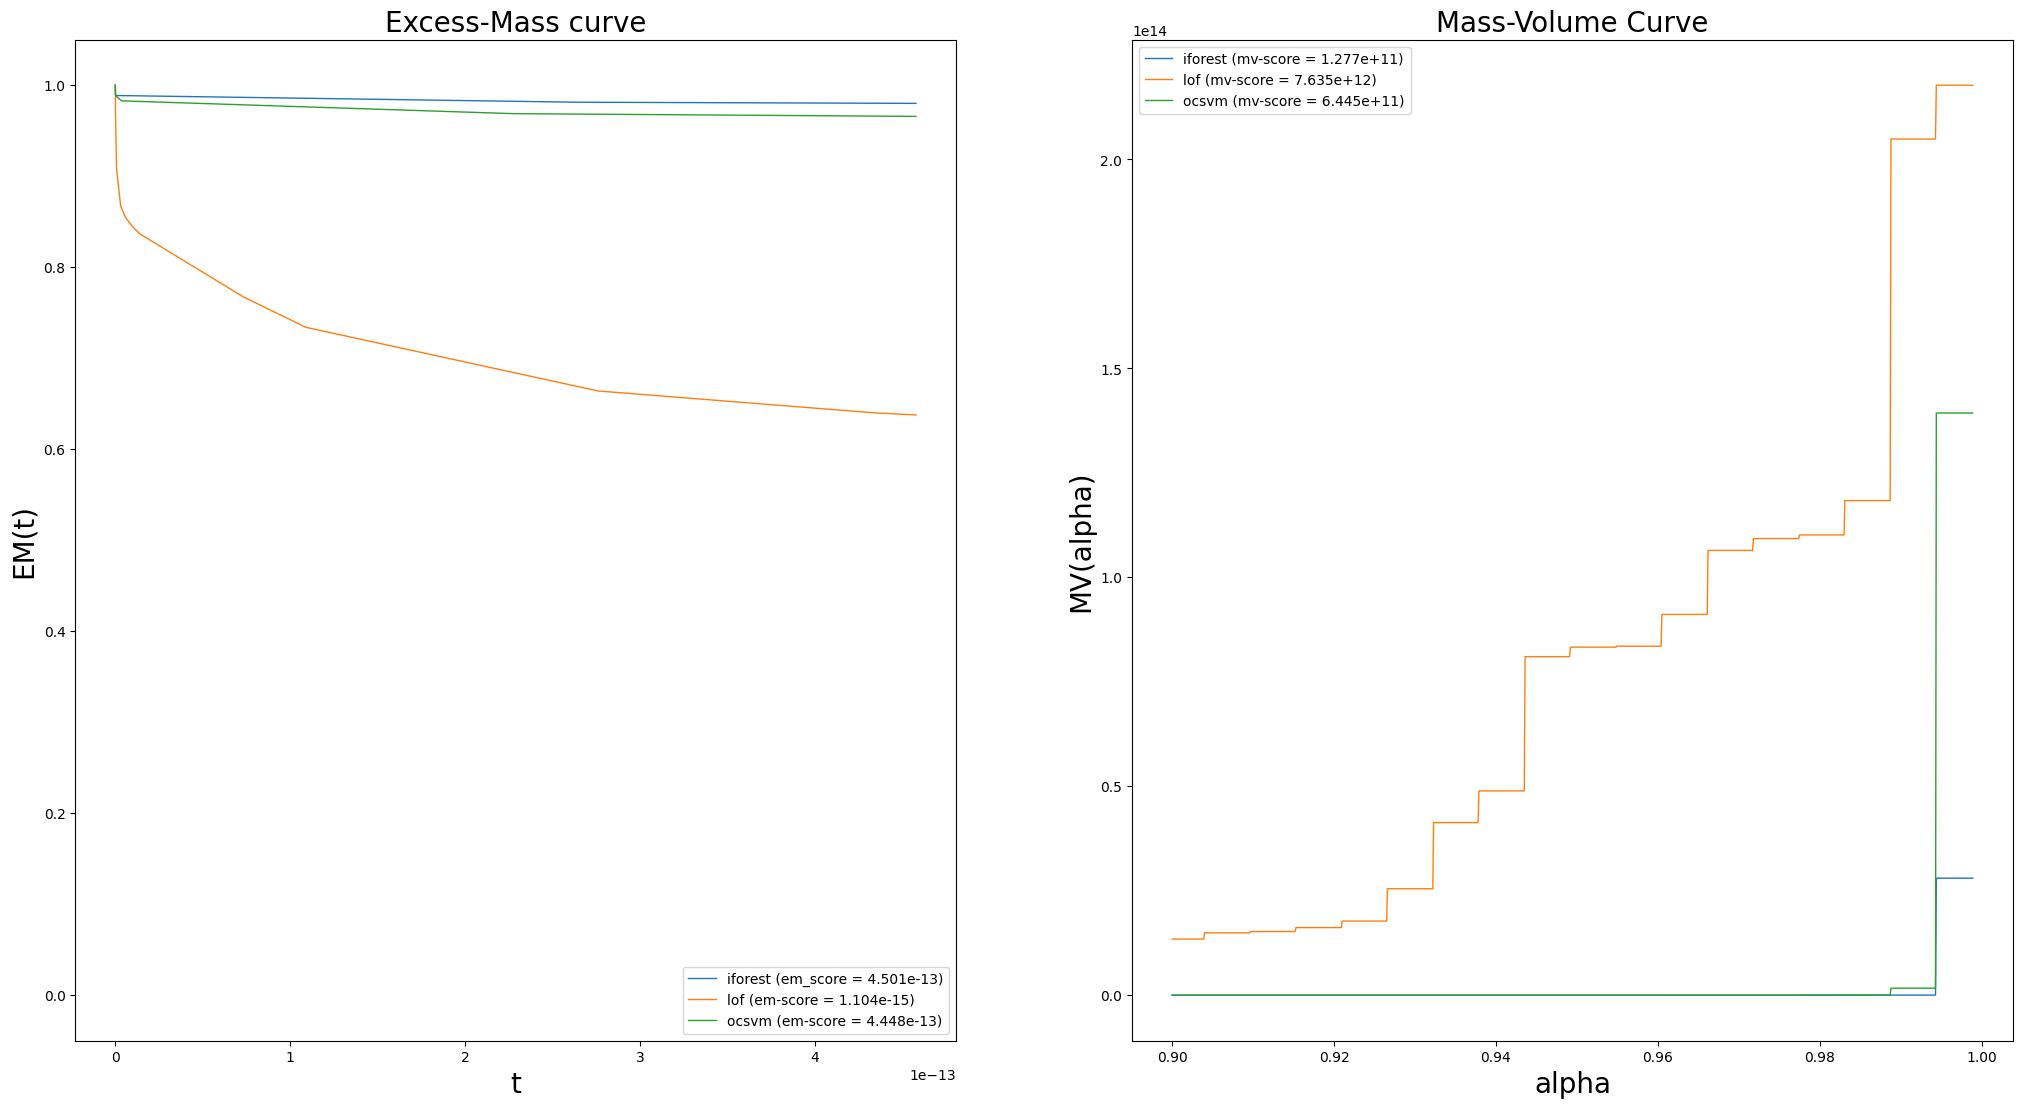

IsolationForest processing...
LocalOutlierFactor processing...
OneClassSVM processing...

 failed to achieve t_max 


 failed to achieve t_max 



KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

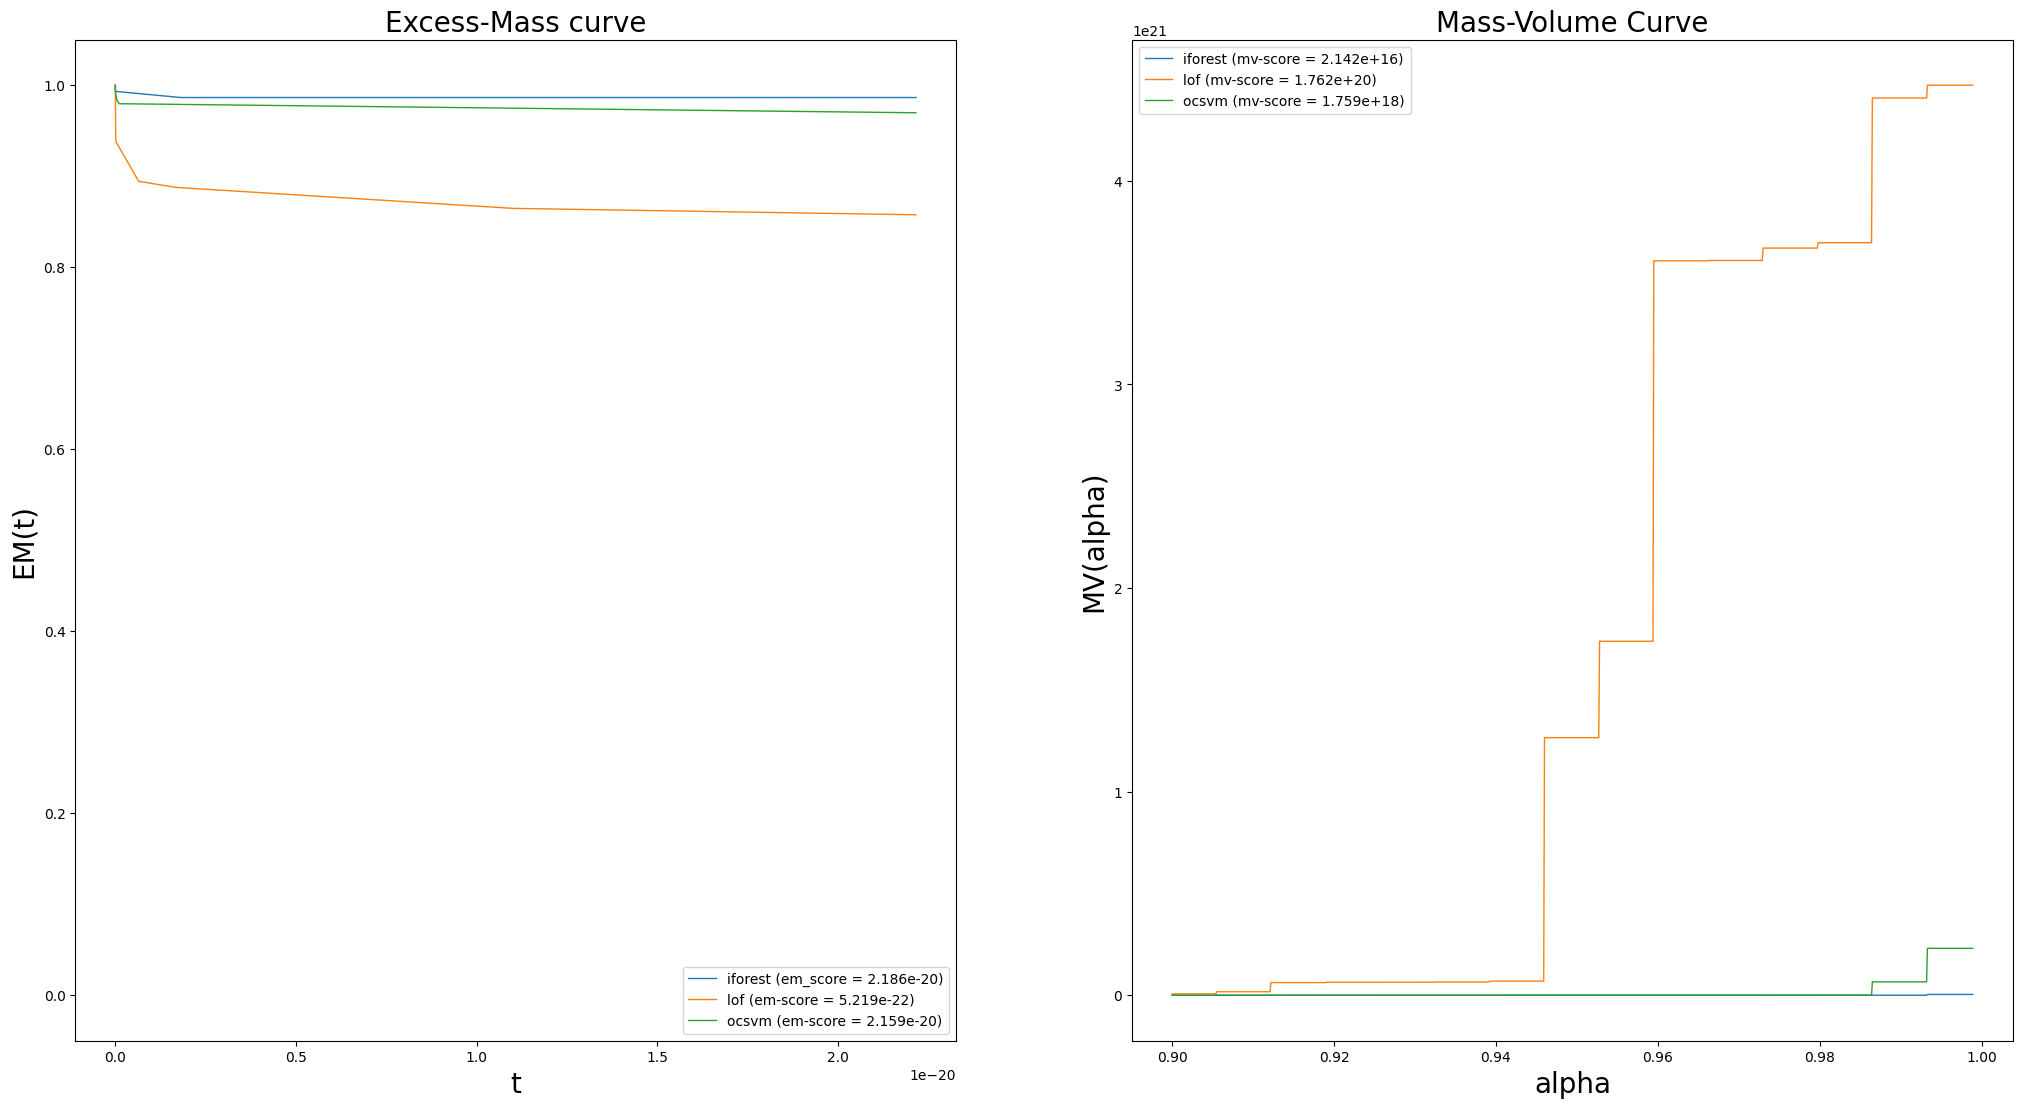

In [35]:
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np

from em import em, mv
df_fraud = df.drop(['Account', 'to_account', 'to_name', 'Date', 'Time', 'Transaction_ID', 'Employment', 'Day', 'Month', 'Income'], axis=1)
scores = {'em':[0,0,0], 'mv':[0,0,0]}

for account in df['Account'].sample(10):
        temp = df_fraud[df.Account == account]
        temp = temp.loc[:, (temp != 0).any(axis=0)]
        std_scale = preprocessing.StandardScaler().fit(temp)
        train_norm = std_scale.transform(temp)
        training_norm_col = pd.DataFrame(train_norm, index=temp.index, columns=temp.columns) 
        temp.update(training_norm_col)
        # parameters of the algorithm:
        n_generated = 100000
        alpha_min = 0.9
        alpha_max = 0.999
        t_max = 0.9
        ocsvm_max_train = 10000

        np.random.seed(1)

        plt.clf()
        plt.figure(figsize=(25, 13))

        # loading and vectorization
        X= np.array(temp)

        n_samples, n_features = np.shape(X)
        n_samples_train = n_samples // 2
        n_samples_test = n_samples - n_samples_train

        X_train = X[:n_samples_train, :]
        X_test = X[n_samples_test:, :]

        # define models:
        iforest = IsolationForest()
        lof = LocalOutlierFactor(n_neighbors=20)
        ocsvm = OneClassSVM()

        lim_inf = X.min(axis=0)
        lim_sup = X.max(axis=0)
        volume_support = (lim_sup - lim_inf).prod()
        t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                size=(n_generated, n_features))

        # fit:
        print('IsolationForest processing...')
        iforest = IsolationForest()
        iforest.fit(X_train)
        s_X_iforest = iforest.decision_function(X_test)
        print('LocalOutlierFactor processing...')
        lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
        lof.fit(X_train)
        s_X_lof = lof.decision_function(X_test)
        print('OneClassSVM processing...')
        ocsvm = OneClassSVM()
        ocsvm.fit(X_train[:min(ocsvm_max_train, n_samples_train - 1)])
        s_X_ocsvm = ocsvm.decision_function(X_test).reshape(1, -1)[0]
        s_unif_iforest = iforest.decision_function(unif)
        s_unif_lof = lof.decision_function(unif)
        s_unif_ocsvm = ocsvm.decision_function(unif).reshape(1, -1)[0]
        plt.subplot(121)
        auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                                volume_support,
                                                s_unif_iforest,
                                                s_X_iforest, n_generated)

        auc_lof, em_lof, amax_lof = em(t, t_max, volume_support,
                                        s_unif_lof, s_X_lof, n_generated)

        auc_ocsvm, em_ocsvm, amax_ocsvm = em(t, t_max, volume_support,
                                                s_unif_ocsvm, s_X_ocsvm,
                                                n_generated)
        if amax_iforest == -1 or amax_lof == -1 or amax_ocsvm == -1:
                amax = -1
        else:
                amax = max(amax_iforest, amax_lof, amax_ocsvm)
        plt.subplot(121)
        plt.plot(t[:amax], em_iforest[:amax], lw=1,
                label='%s (em_score = %0.3e)'
                % ('iforest', auc_iforest))
        plt.plot(t[:amax], em_lof[:amax], lw=1,
                label='%s (em-score = %0.3e)'
                % ('lof', auc_lof))
        plt.plot(t[:amax], em_ocsvm[:amax], lw=1,
                label='%s (em-score = %0.3e)'
                % ('ocsvm', auc_ocsvm))
        mylist1 = [auc_iforest, auc_lof, auc_ocsvm]
        scores['em'][mylist1.index(max(mylist1))]+=1
        plt.ylim([-0.05, 1.05])
        plt.xlabel('t', fontsize=20)
        plt.ylabel('EM(t)', fontsize=20)
        plt.title('Excess-Mass curve', fontsize=20)
        plt.legend(loc="lower right")


        plt.subplot(122)
        auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                        s_unif_iforest, s_X_iforest, n_generated)
        auc_lof, mv_lof = mv(axis_alpha, volume_support,
                                s_unif_lof, s_X_lof, n_generated)
        auc_ocsvm, mv_ocsvm = mv(axis_alpha, volume_support,
                                s_unif_ocsvm, s_X_ocsvm, n_generated)
        plt.plot(axis_alpha, mv_iforest, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('iforest', auc_iforest))
        plt.plot(axis_alpha, mv_lof, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('lof', auc_lof))
        plt.plot(axis_alpha, mv_ocsvm, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('ocsvm', auc_ocsvm))
        mylist1 = [auc_iforest, auc_lof, auc_ocsvm]
        scores['mv'][mylist1.index(max(mylist1))]+=1
        # plt.xlim([-0.05, 1.05])
        # plt.ylim([-0.05, 100])
        plt.xlabel('alpha', fontsize=20)
        plt.ylabel('MV(alpha)', fontsize=20)
        plt.title('Mass-Volume Curve', fontsize=20)
        plt.legend(loc="upper left")

        plt.savefig('unsup_mv_em__unsupervised_09_factorized')
        plt.savefig('mv_em__unsupervised_09_factorized')

        plt.savefig('mv_em__supervised'
                + '_alphamin' + str(int(100 * alpha_min)) + '_'
                + '_n_generated' + str(n_generated) + '_'
                + '_ocsvm' + str(ocsvm_max_train) + '_'
                + '_factorized_pruning')

        plt.show()

print(scores)

In [ ]:
def test_iforest(params, temp):
        n_generated = 100000
        alpha_min = 0.9
        alpha_max = 0.999
        t_max = 0.9
        ocsvm_max_train = 10000

        np.random.seed(1)

        plt.clf()
        plt.figure(figsize=(25, 13))

        # loading and vectorization
        X= np.array(temp)

        n_samples, n_features = np.shape(X)
        n_samples_train = n_samples // 2
        n_samples_test = n_samples - n_samples_train

        X_train = X[:n_samples_train, :]
        X_test = X[n_samples_test:, :]

        # define models:
        iforest = IsolationForest(params)

        lim_inf = X.min(axis=0)
        lim_sup = X.max(axis=0)
        volume_support = (lim_sup - lim_inf).prod()
        t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                size=(n_generated, n_features))

        # fit:
        print('IsolationForest processing...')
        iforest = IsolationForest()
        iforest.fit(X_train)
        s_X_iforest = iforest.decision_function(X_test)
 
        s_unif_iforest = iforest.decision_function(unif)
        plt.subplot(121)
        em_auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                                volume_support,
                                                s_unif_iforest,
                                                s_X_iforest, n_generated)


 
        amax = amax_iforest
        plt.subplot(121)
        plt.plot(t[:amax], em_iforest[:amax], lw=1,
                label='%s (em_score = %0.3e)'
                % ('iforest', em_auc_iforest))

        plt.ylim([-0.05, 1.05])
        plt.xlabel('t', fontsize=20)
        plt.ylabel('EM(t)', fontsize=20)
        plt.title('Excess-Mass curve', fontsize=20)
        plt.legend(loc="lower right")


        plt.subplot(122)
        mv_auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                        s_unif_iforest, s_X_iforest, n_generated)

        plt.plot(axis_alpha, mv_iforest, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('iforest', mv_auc_iforest))

        # plt.xlim([-0.05, 1.05])
        # plt.ylim([-0.05, 100])
        plt.xlabel('alpha', fontsize=20)
        plt.ylabel('MV(alpha)', fontsize=20)
        plt.title('Mass-Volume Curve', fontsize=20)
        plt.legend(loc="upper left")


        plt.show()

        return(em_auc_iforest, mv_auc_iforest)
